Reproduce and translate the contents of `../../jzb/data/test_load_rawdata.m` from Matlab to Python.

To run this script you'll need to install a few packages. The easy way around this (on the H2 cluster) is to do the following:
```
module load anaconda3
module load NCCL
source activate /private/home/mikerabbat/.conda/envs/fast_mri
```

That environment is based on `fair_env_latest_py3` (cloned on May 31, 2018), so it has PyTorch 0.4. It also has the ISMRMRD package (https://github.com/ismrmrd/ismrmrd-python) which can be used to load the data files, and the PyXB package (https://github.com/pabigot/pyxb) on which ISMRMRD depends.

To get this to work with our setup, I had to make a very small modification to the ISMRMRD package before installing it. In line 152 of `ismrmrd/hdf5.py`, I changed `'r+'` to `'r'`. This avoids permission errors when trying to read a data file. It is necessary since most of us only have read access to the data, and anyways, we don't need to be editing/appending to these files, so it's also safer. 

If you use the environment above (which also already has pytorch-fft installed) then you don't need to worry about 
installing either of those packages or making the changes.

In [60]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]
import sys
sys.path.insert(0,'ismrmrd-python-master')
import ismrmrd
from numpy.fft import fftshift, ifftshift, ifft

In [7]:
# Path info
dataroot = '/checkpoint02/jzb/data/nyu/raw_data/'
datadir = 'PETMR/FBAI_Liver/'
filename = 'FBAI_Liver#SPETMR#F113814#M1221#D300118#T172300#AXT2FSABD_FBL_1.h5'

In [8]:
# Read the datafile and extract header information
dset = ismrmrd.Dataset(dataroot+datadir+filename, 'dataset', create_if_needed=False)
hdr = ismrmrd.xsd.CreateFromDocument(dset.read_xml_header())
enc = hdr.encoding[0]

In [9]:
# Matrix sizes
enc_Nx = enc.encodedSpace.matrixSize.x
enc_Ny = enc.encodedSpace.matrixSize.y
enc_Nz = enc.encodedSpace.matrixSize.z
print('encodedSpace.matrixSize', str([enc_Nx, enc_Ny, enc_Nz]))

rec_Nx = enc.reconSpace.matrixSize.x
rec_Ny = enc.reconSpace.matrixSize.y
rec_Nz = enc.reconSpace.matrixSize.z
print('reconSpace.matrixSize', str([rec_Nx, rec_Ny, rec_Nz]))


# Here's how to get the field of view parameters in case they're needed in the future
# enc_FOVx = enc.encodedSpace.fieldOfView_mm.x
# enc_FOVy = enc.encodedSpace.fieldOfView_mm.y
# enc_FOVz = enc.encodedSpace.fieldOfView_mm.z

# rec_FOVx = enc.reconSpace.fieldOfView_mm.x
# rec_FOVy = enc.reconSpace.fieldOfView_mm.y
# rec_FOVz = enc.reconSpace.fieldOfView_mm.z


encodedSpace.matrixSize [512, 266, 1]
reconSpace.matrixSize [256, 256, 1]


In [10]:
# Other parameters
if enc.encodingLimits.slice != None:
    nslices = enc.encodingLimits.slice.maximum + 1
else:
    nslices = 1
print('nslices', nslices)
    
if hdr.acquisitionSystemInformation.receiverChannels != None:
    ncoils = hdr.acquisitionSystemInformation.receiverChannels
else:
    ncoils = 1
print('ncoils', ncoils)
    
if enc.encodingLimits.repetition != None:
    nreps = enc.encodingLimits.repetition.maximum + 1
else:
    nreps = 1
print('nreps', nreps)
    
if enc.encodingLimits.contrast != None:
    ncontrasts = enc.encodingLimits.contrast.maximum + 1
else:
    ncontrasts = 1
print('ncontrasts', ncontrasts)
    
    

nslices 3
ncoils 12
nreps 1
ncontrasts 1


In [11]:
# Ignore noise scans
firstscan = 0
while True:
    acq = dset.read_acquisition(firstscan)
    if acq.isFlagSet(ismrmrd.ACQ_IS_NOISE_MEASUREMENT):
        firstscan += 1
    else:
        break


In [12]:
# Load data
nacq = dset.number_of_acquisitions()
kdata = np.zeros((nreps, ncontrasts, nslices, enc_Nx, enc_Ny, enc_Nz, ncoils), dtype=np.complex64)
for scan in range(firstscan, nacq):
    acq = dset.read_acquisition(scan)
    rep = acq.idx.repetition
    contrast = acq.idx.contrast
    sl = acq.idx.slice
    ky = acq.idx.kspace_encode_step_1
    kz = acq.idx.kspace_encode_step_2
    kdata[rep, contrast, sl, :, ky, kz, :] = acq.data.T


In [21]:
# Reconstruct
recon_images = []
for rep in range(nreps):
    for contrast in range(ncontrasts):
        for sl in range(nslices):
            # Grab the slice of data for this image
            K = kdata[rep, contrast, sl, :, :, :, :]
            # Reconstruct in x
            K = fftshift(ifft(fftshift(K, axes=0), axis=0), axes=0)
            # Chop if needed
            if enc_Nx == rec_Nx:
                im = K
            else:
                ind1 = (enc_Nx - rec_Nx) // 2
                ind2 = (enc_Nx - rec_Nx) // 2 + rec_Nx
                im = K[ind1:ind2,:,:,:]
            # Reconstruct in y then z
            import pdb; pdb.set_trace()
            im = fftshift(ifft(fftshift(im, axes=1), axis=1), axes=1)
            import pdb; pdb.set_trace()
            if im.shape[2] > 1:
                im = fftshift(ifft(fftshift(im, axes=2), axis=2), axes=2)
            # Combine SOS across coils
            im = np.sqrt(np.sum(np.abs(im) ** 2, axis=3))
            # Append to the list
            recon_images.append(im)


> <ipython-input-21-61c79dc5949e>(19)<module>()
-> im = fftshift(ifft(fftshift(im, axes=1), axis=1), axes=1)
(Pdb) im.shape
(256, 266, 1, 12)
--KeyboardInterrupt--
(Pdb) quot
*** NameError: name 'quot' is not defined
(Pdb) quit


BdbQuit: 

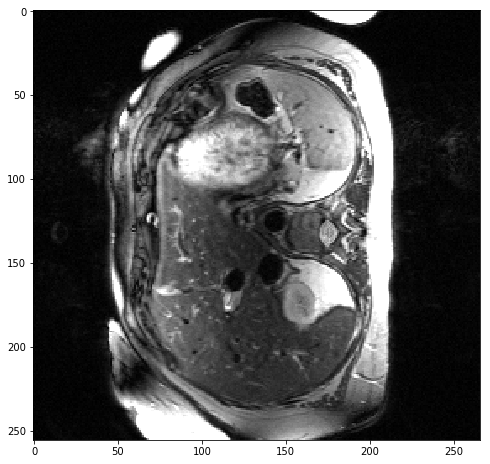

In [117]:
recon_images = []
K = kdata[0, 0, 0, :, :, :, :]
# Reconstruct in x
K = fftshift(ifft(fftshift(K, axes=0), axis=0), axes=0)
# K = ifft(K, axis=0)
# iff_1dk = K
# Chop if needed
if enc_Nx == rec_Nx:
    im = K
else:
    ind1 = (enc_Nx - rec_Nx) // 2
    ind2 = (enc_Nx - rec_Nx) // 2 + rec_Nx
    im = K[ind1:ind2,:,:,:]

# im = K
iff_1dk = im
# Reconstruct in y then z
im = fftshift(ifft(fftshift(im, axes=1), axis=1), axes=1)
# im = ifft(im, axis=1)

if im.shape[2] > 1:
    im = fftshift(ifft(fftshift(im, axes=2), axis=2), axes=2)
iff_2dk = im
# Combine SOS across coils
im = np.sqrt(np.sum(np.abs(im) ** 2, axis=3))
recon_images.append(im)
plt.imshow(np.fliplr(np.flipud(recon_images[sl][:,:,0])), vmin=3.94e-08, vmax=1e-06, cmap='gray')
# plt.imshow(np.fliplr(np.flipud(im[:,:,0,4].real)), vmin=3.94e-08, vmax=1e-06, cmap='gray')

In [111]:
im.shape

(256, 266, 1)

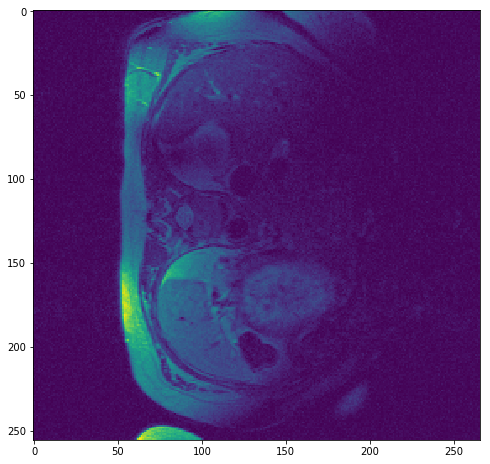

In [151]:
K = iff_2dk
# Reconstruct in x
# K = fftshift(ifft(fftshift(K, axes=0), axis=0), axes=0)
# K = ifft(K, axis=0)
plt.imshow(np.absolute(K[:,:,0,4]))

Text(0.5,1,'1dfft raw data')

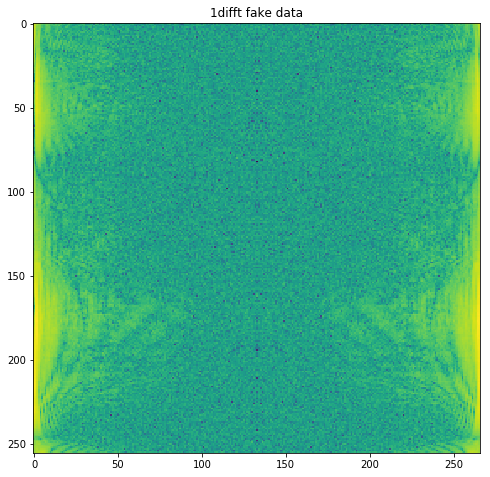

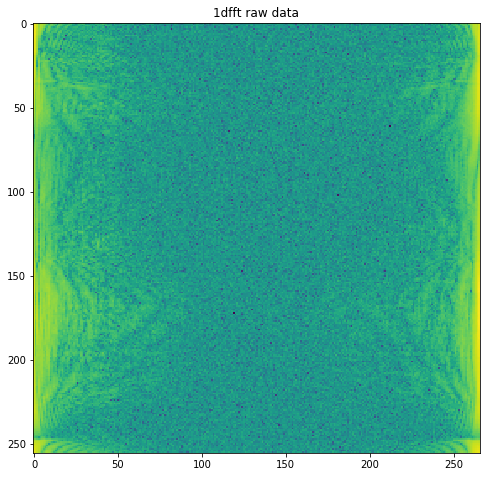

In [183]:
im_c = iff_2dk[:,:,0,4].real
import scipy.misc as misc
# im_c = misc.imresize(im_c, (256,256))

fft1d = np.fft.fft(im_c, axis=1)
plt.imshow(np.log(np.absolute(fft1d)))
plt.title('1difft fake data')
fft1d2 = ifftshift(iff_1dk[:,:,0,4], axes=1)
plt.figure()
plt.imshow(np.log(np.absolute(fft1d2)))
plt.title('1dfft raw data')

In [139]:
im_c.shape

(256, 266)

In [184]:
fft1d2[:,10]

array([ 1.92796415e-06-1.35119581e-06j,  2.19919502e-06-1.43190653e-06j,
        1.74248305e-06-4.24823838e-07j,  1.12363512e-06-8.58464773e-07j,
        7.05589059e-07-8.77090315e-07j, -2.69974862e-07-4.29730562e-07j,
       -9.41302233e-07-9.35769776e-07j, -8.09621724e-07-7.86658461e-07j,
       -1.21518167e-06-3.33660637e-08j, -1.56901319e-06+6.19267041e-07j,
       -1.74105526e-06+3.93334631e-07j, -2.03564969e-06+4.73259888e-07j,
       -1.54358418e-06-1.22671963e-07j, -1.03143498e-06-2.47497610e-07j,
       -2.51188112e-07+1.55628641e-07j, -1.68347924e-07+4.12380359e-07j,
       -2.70940063e-07-7.07832442e-08j, -5.73205853e-07+1.01951628e-07j,
        4.20850483e-07+9.57188604e-07j,  8.08745426e-07+5.54573489e-07j,
       -1.06741936e-07-3.63973413e-07j, -1.97855570e-07-1.18381797e-06j,
        4.42290798e-07-5.24078814e-07j,  4.01545435e-07-4.38810275e-07j,
        2.98576651e-07-1.04834407e-06j,  4.64183586e-07-6.50928996e-07j,
       -2.32158300e-07+2.36741073e-07j, -8.22999823

<IPython.core.display.Javascript object>


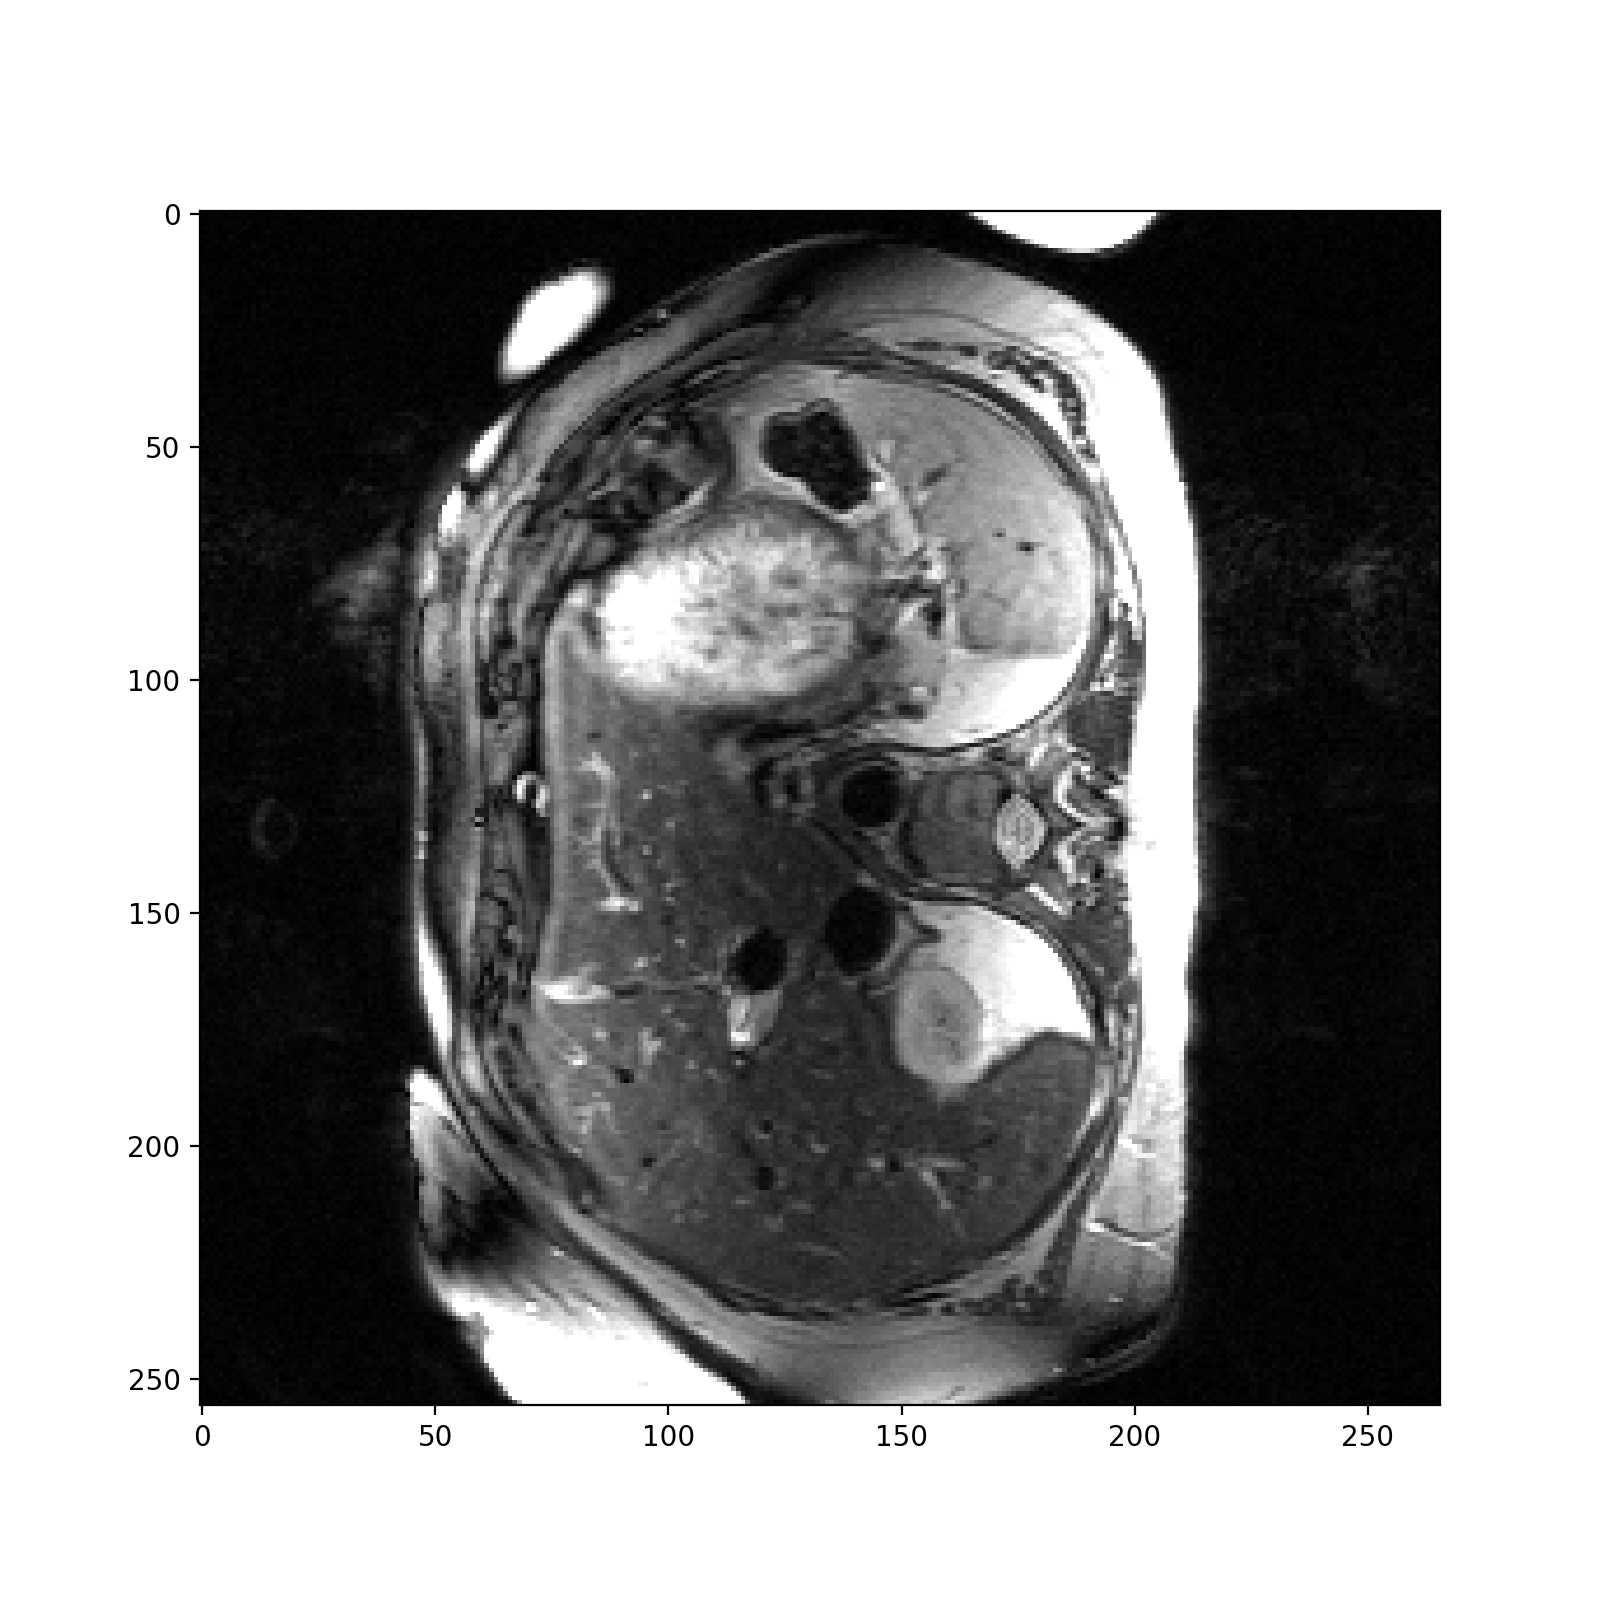

In [14]:
# Display the first image
sl = 0
plt.figure()
plt.imshow(np.fliplr(np.flipud(recon_images[sl][:,:,0])), vmin=3.94e-08, vmax=1e-06, cmap='gray')